In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import boxcox, yeojohnson
from scipy import stats

import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from IPython.display import Markdown


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("../data/bank/bank-full.csv",sep=';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
df.shape

(45211, 17)

# Data Preprocessing

In [6]:
df.isna().any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [7]:
df.isin([-np.inf,np.inf]).any()

age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [8]:
# dropping balance and day to be compliant with new unseen dataset
df = df.drop(columns=['balance','day'])

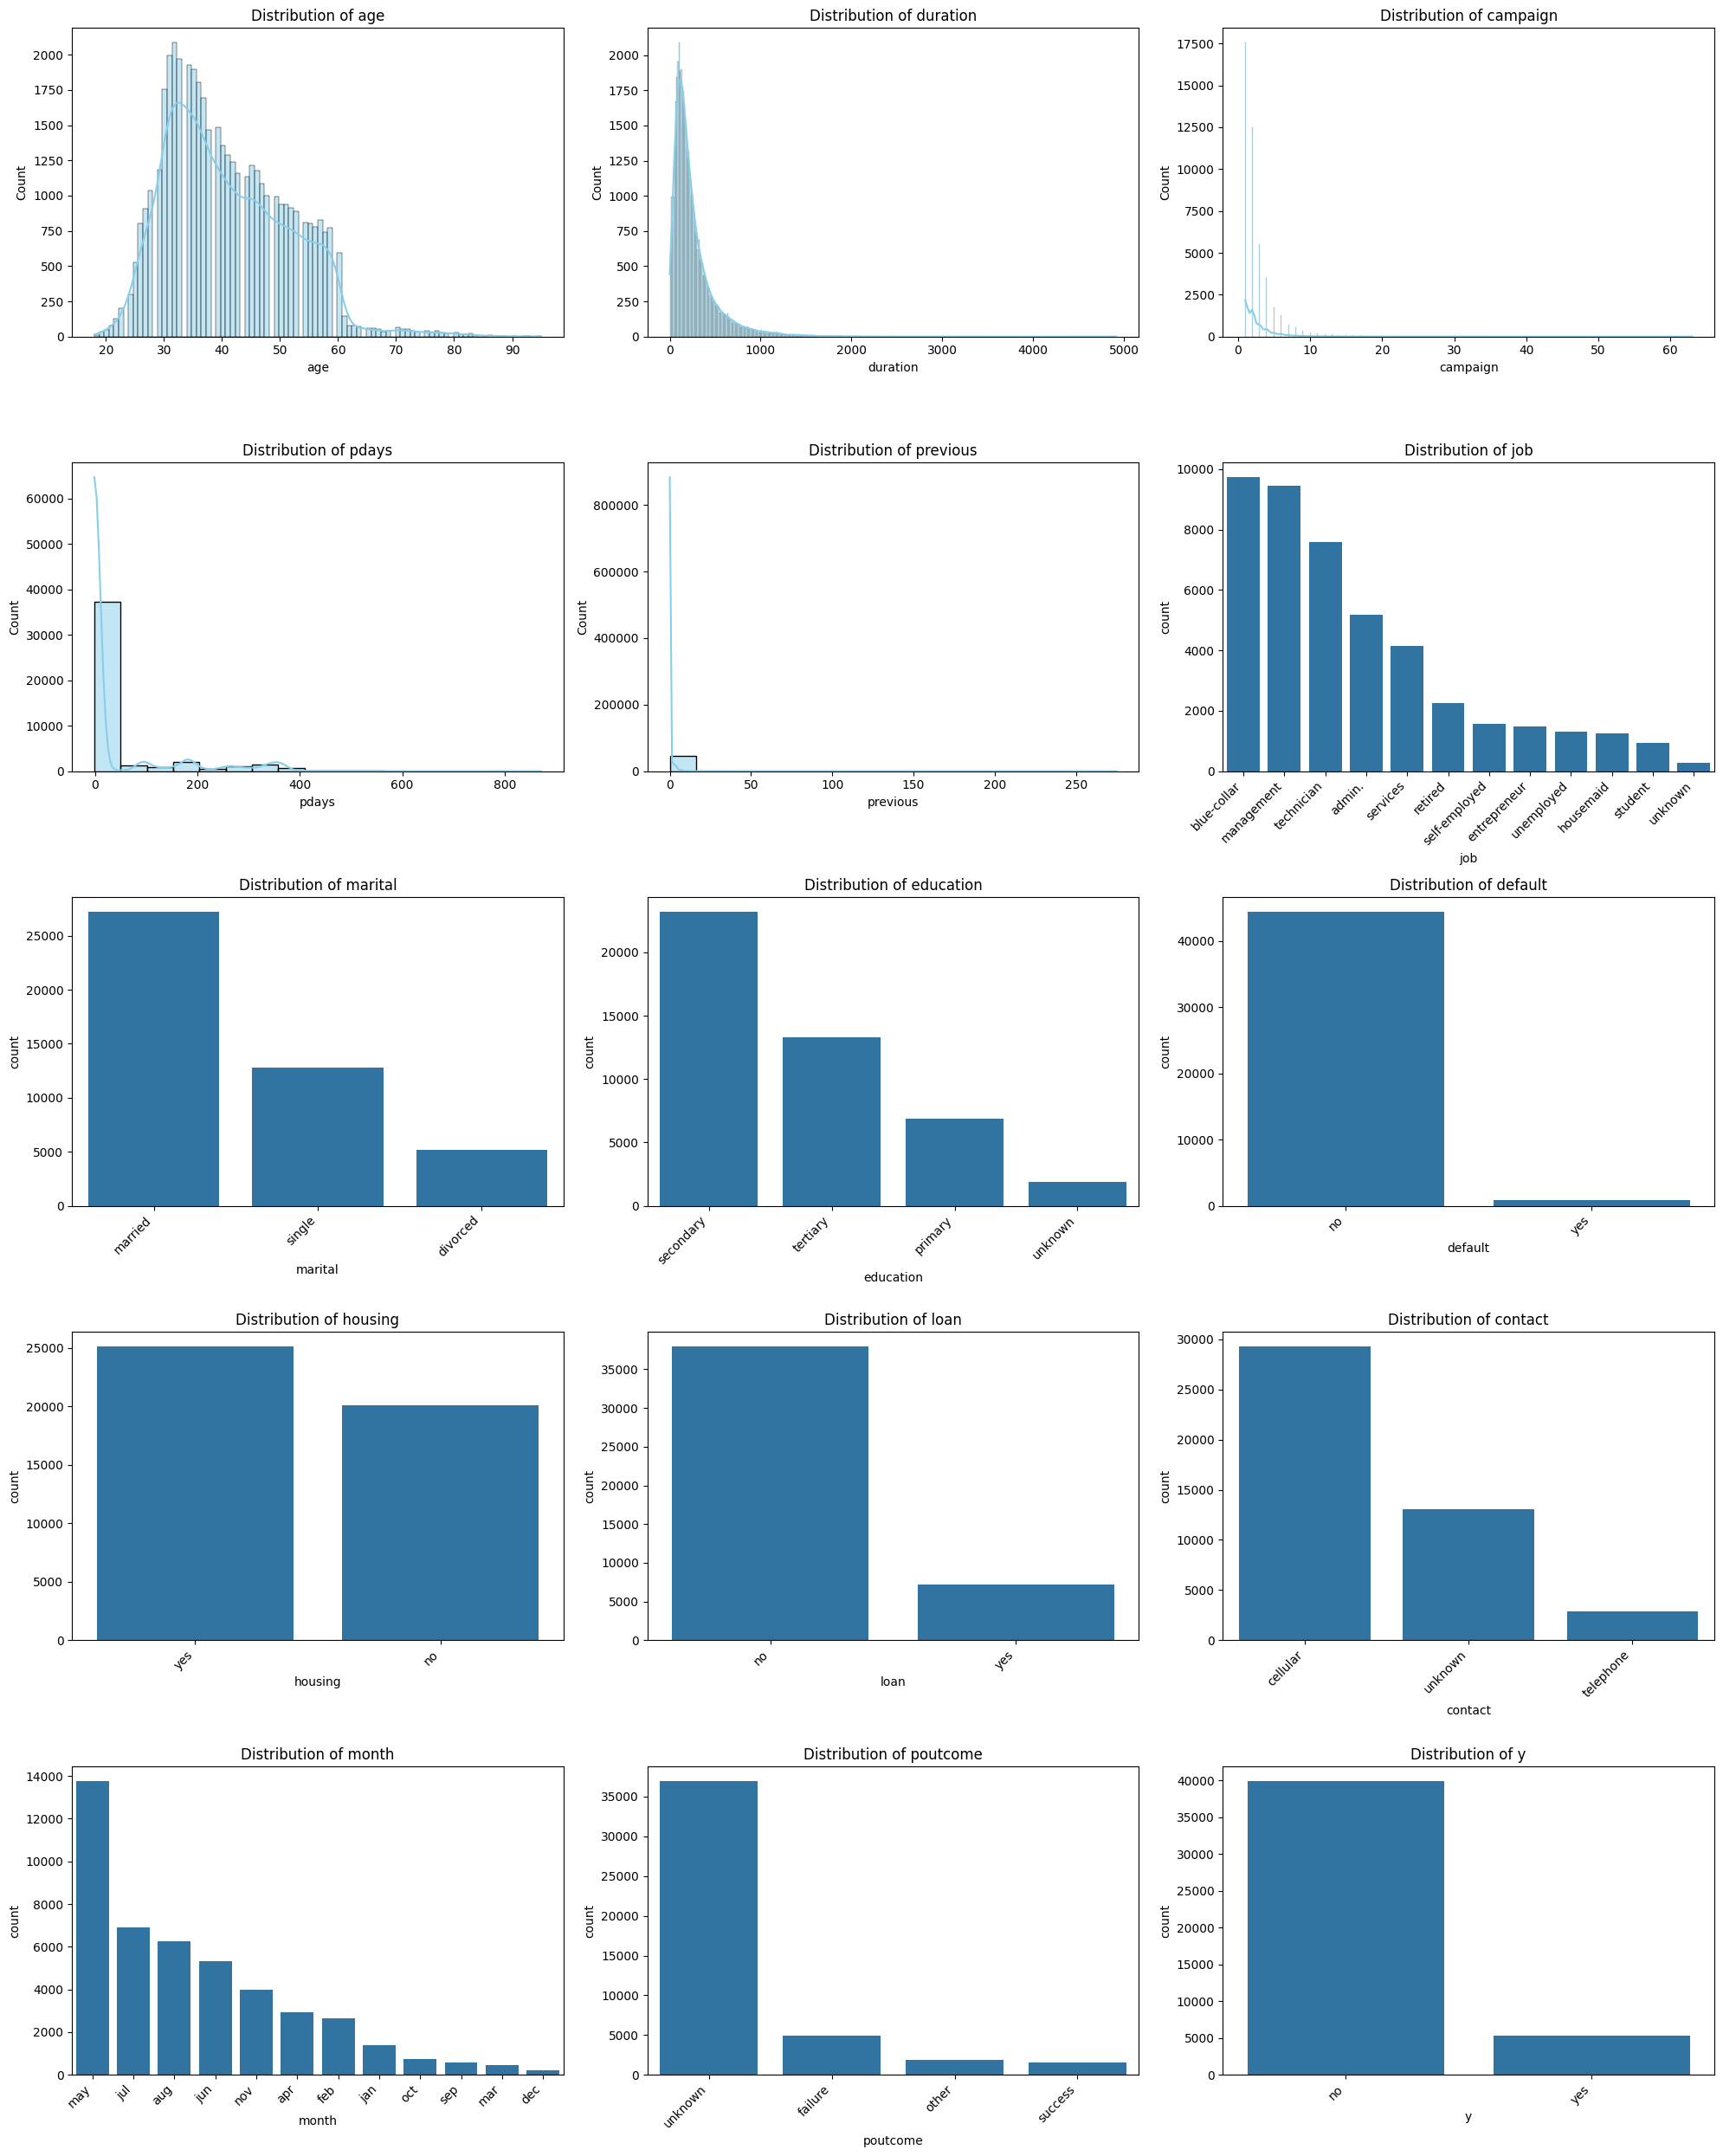

In [9]:
# Identify numeric and categorical columns
numeric_cols = ['age', 'duration', 'campaign', 'pdays', 'previous']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

# Set up the grid size
total_cols = numeric_cols + categorical_cols
n_cols = 3  # number of columns in the grid
n_rows = (len(total_cols) + n_cols - 1) // n_cols  # auto-calculate rows

plt.figure(figsize=(20, n_rows * 5))  # adjust figure size

for idx, col in enumerate(total_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    
    if col in numeric_cols:
        sns.histplot(df[col], kde=True, color='skyblue')
    else:
        order = df[col].value_counts().index  # sort bars by frequency
        sns.countplot(x=col, data=df, order=order)
        plt.xticks(rotation=45, ha='right')
        
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.savefig("plots/distribution-plots.png")
plt.show()

In [10]:
#df['balance_transformed'] = np.arcsinh(df['balance'])

In [11]:
df['duration_boxcox'], lambda_val = stats.boxcox(df['duration'] + 0.1)

In [12]:
df['campaign_cbrt'] = np.cbrt(df['campaign'])

In [13]:
# Suppress the specific warning
with np.errstate(invalid='ignore'):
    df['pdays_special'] = (df['pdays'] == -1).astype(int)
    df['pdays_transformed'] = np.where(df['pdays'] > 0, np.log(df['pdays']), 0)

In [14]:
df['had_previous'] = (df['previous'] > 0).astype(int)

In [15]:
df['age_scaled'] = StandardScaler().fit_transform(df[['age']])

In [16]:
df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'contact', 'poutcome'], drop_first=True)

In [17]:
# Map months to numbers
month_mapping = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 
                 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
df['month_num'] = df['month'].map(month_mapping)

# Create cyclical features
df['month_sin'] = np.sin(2 * np.pi * df['month_num']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num']/12)

In [18]:
df.columns

Index(['age', 'default', 'housing', 'loan', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'y', 'duration_boxcox', 'campaign_cbrt',
       'pdays_special', 'pdays_transformed', 'had_previous', 'age_scaled',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_telephone',
       'contact_unknown', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'month_num', 'month_sin', 'month_cos'],
      dtype='object')

In [19]:
columns_to_drop = [
    'age', 'duration', 'campaign', 'pdays', 'previous','month'
]
df = df.drop(columns=columns_to_drop)

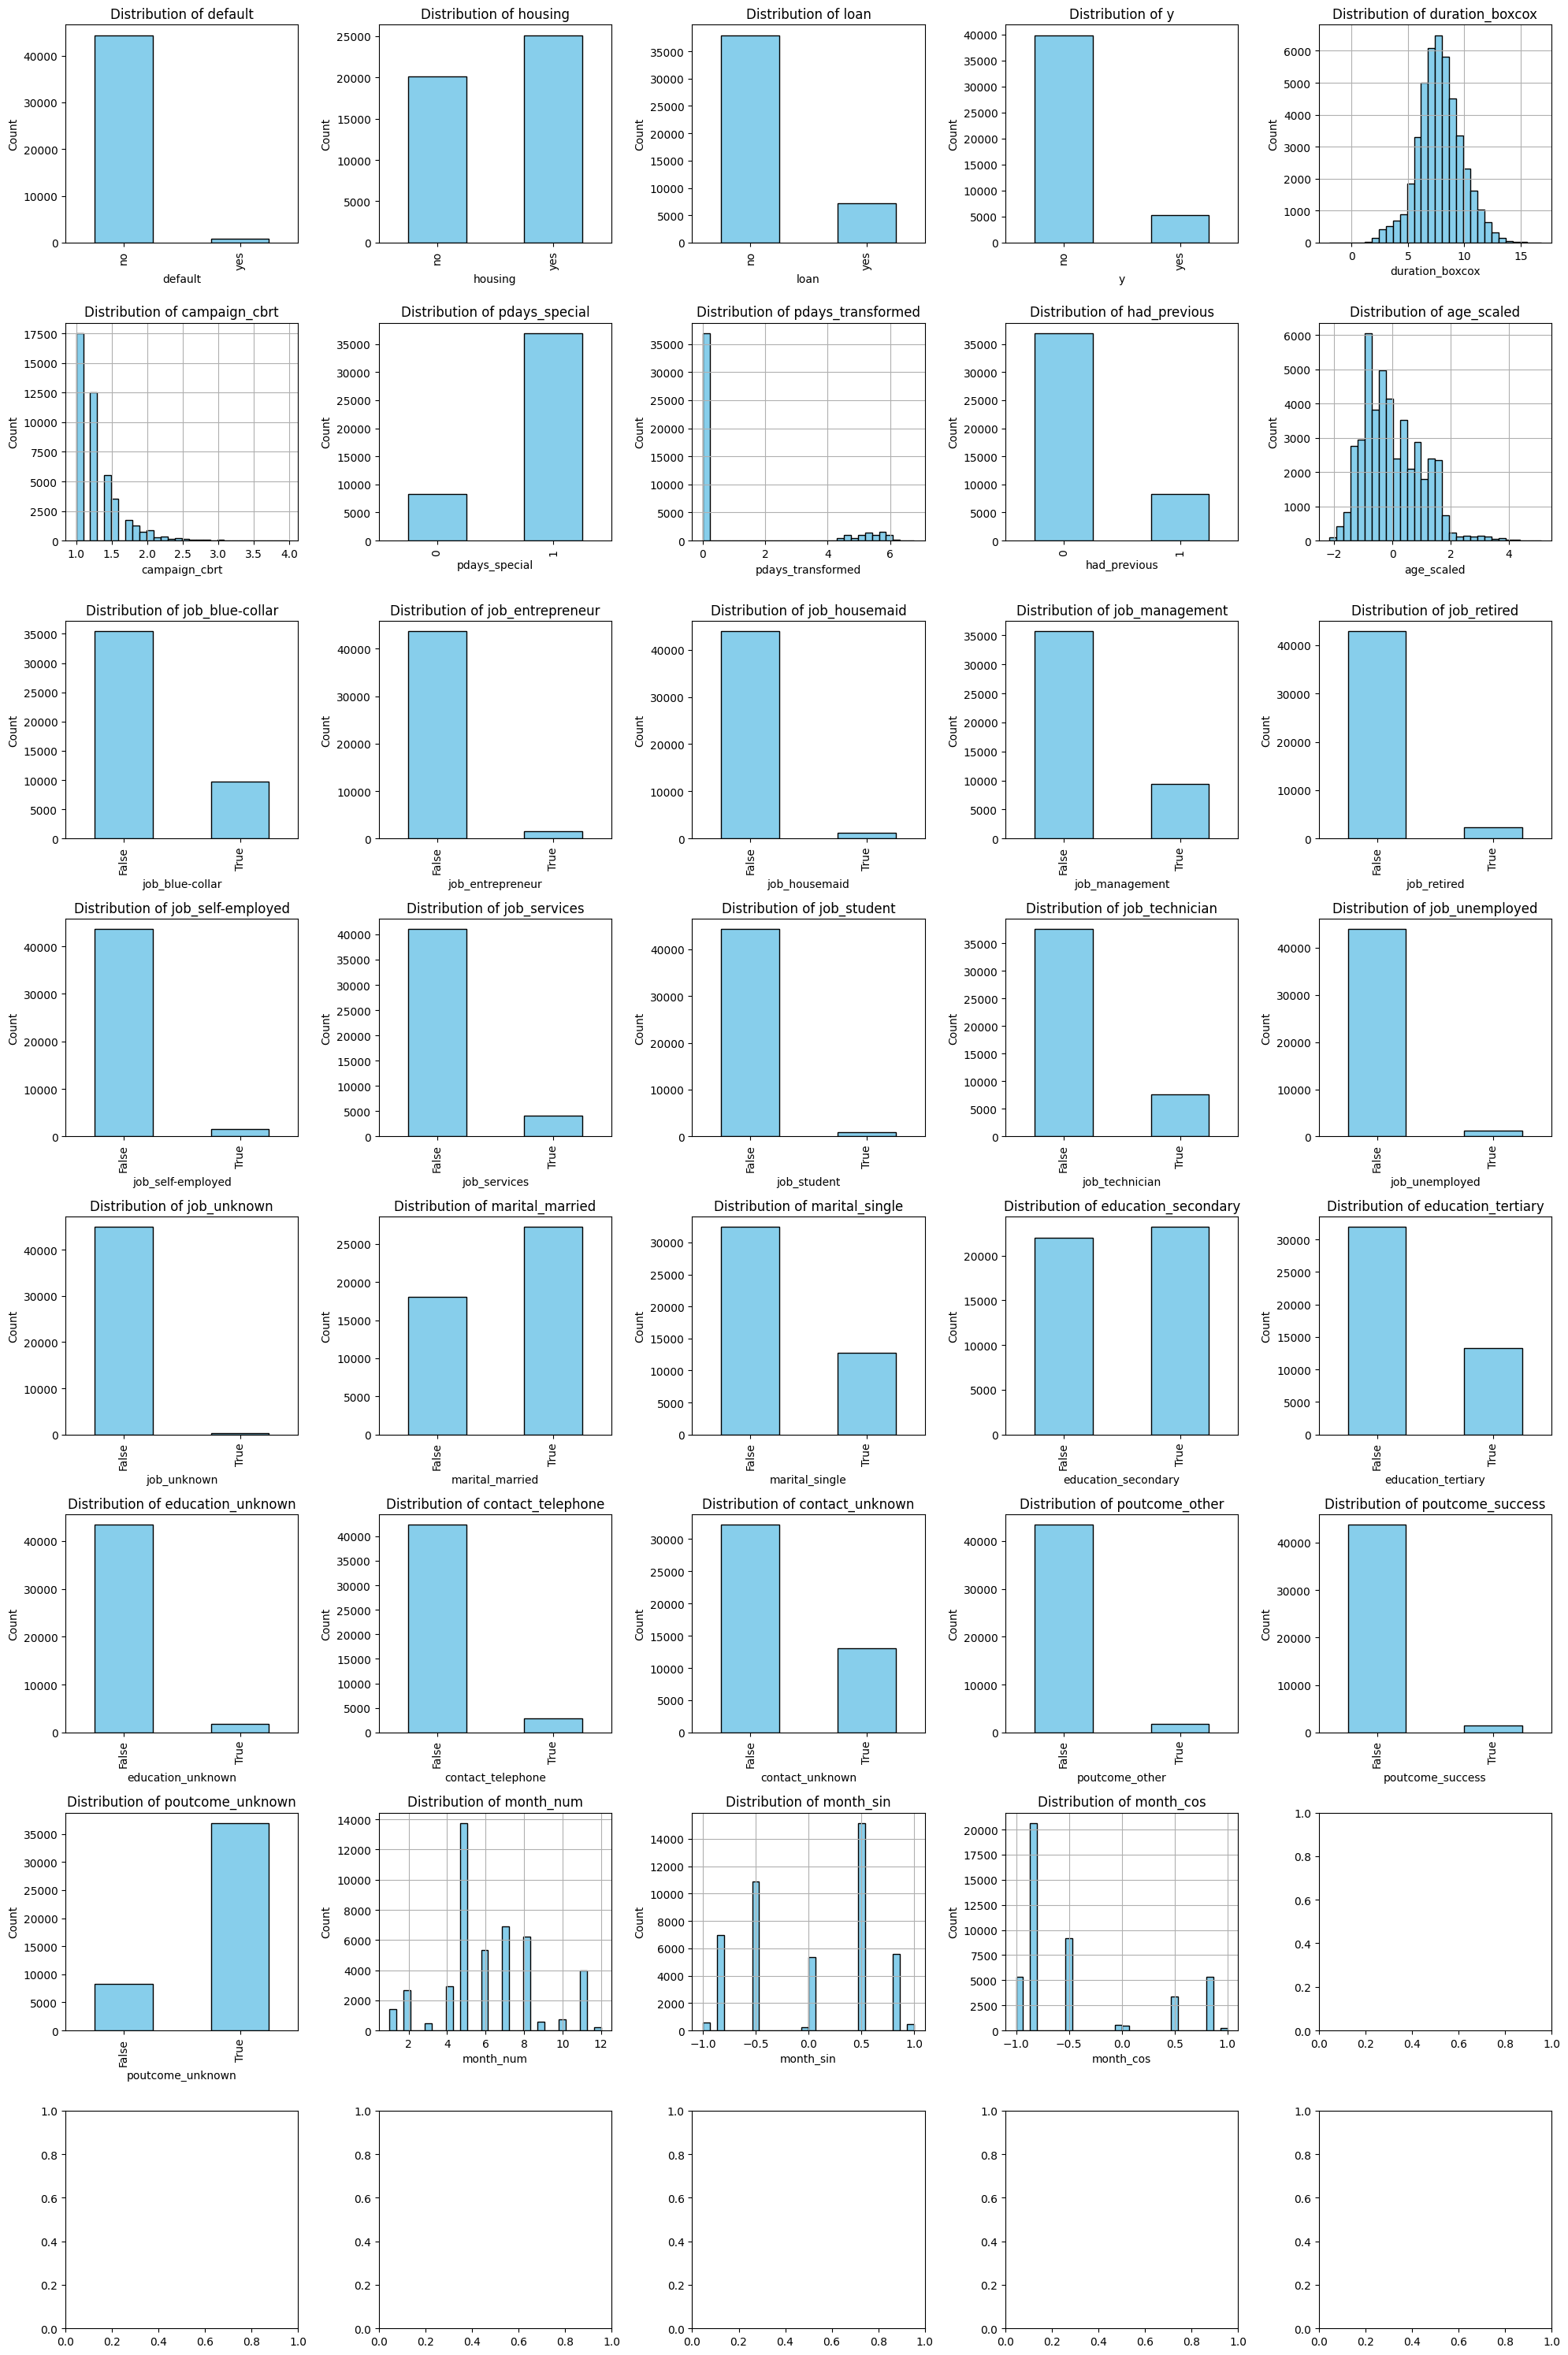

In [20]:
fig, axes = plt.subplots(8, 5, figsize=(20, 30))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    if df[col].nunique() > 10:
        df[col].hist(bins=30, ax=axes[i], color='skyblue', edgecolor='black')
    else:
        df[col].value_counts().sort_index().plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.savefig("plots/distribution-plots-new.png")
plt.show()

In [21]:
yes_no_map = {'yes': True, 'no': False}

for col in ['default', 'housing', 'loan', 'y']:
    df[col] = df[col].map(yes_no_map)

In [22]:
df.dtypes

default                   bool
housing                   bool
loan                      bool
y                         bool
duration_boxcox        float64
campaign_cbrt          float64
pdays_special            int64
pdays_transformed      float64
had_previous             int64
age_scaled             float64
job_blue-collar           bool
job_entrepreneur          bool
job_housemaid             bool
job_management            bool
job_retired               bool
job_self-employed         bool
job_services              bool
job_student               bool
job_technician            bool
job_unemployed            bool
job_unknown               bool
marital_married           bool
marital_single            bool
education_secondary       bool
education_tertiary        bool
education_unknown         bool
contact_telephone         bool
contact_unknown           bool
poutcome_other            bool
poutcome_success          bool
poutcome_unknown          bool
month_num                int64
month_si

In [23]:
df.to_csv("../data/processed/bank-dataset-processed-skewness.csv")